In [1]:
import seml
import pandas as pd

In [226]:
results = seml.get_results('exp021123', to_data_frame=True)

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

In [227]:
groups = results.groupby(["config.addl_dataset_train", "config.n_hidden", "config.n_layers", "config.dropout_rate", "config.weight_decay"])
groups_mean = groups.mean(numeric_only=True)
groups_mean = groups_mean.reset_index()
#groups_extra.mean(numeric_only=True)[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                                'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].sort_values("result.r2_dbdb_OOD", ascending=False)

In [228]:
groups_mean['avg_r2'] = groups_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD','result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].mean(axis=1)
groups_mean['avg_r2_h'] = groups_mean[['result.r2_dbdb_healthy','result.r2_mSTZ_healthy']].mean(axis=1)
groups_mean['avg_r2_OOD'] = groups_mean[['result.r2_dbdb_OOD','result.r2_mSTZ_OOD']].mean(axis=1)

#result_extra_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                   'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD', 'avg_r2', 'avg_r2_h', 'avg_r2_OOD']].sort_values(by='avg_r2_OOD', ascending=False)


In [ ]:
results_merge_genes = seml.get_results('exp021123', to_data_frame=True)

Index(['_id', 'config.overwrite', 'config.db_collection',
       'config.addl_dataset_train', 'config.cov_embed_dims',
       'config.dataset_ground_truth1', 'config.dataset_ground_truth2',
       'config.dataset_to_predict', 'config.dropout_rate', 'config.kl_weight',
       'config.learning_rate', 'config.max_epochs', 'config.n_hidden',
       'config.n_latent', 'config.n_layers', 'config.save_folder_name',
       'config.save_models', 'config.seed', 'config.weight_decay',
       'result.kl_weight', 'result.train_loss_step', 'result.elbo_validation',
       'result.reconstruction_loss_validation', 'result.kl_local_validation',
       'result.kl_global_validation', 'result.dbdb_r2_validation_eval',
       'result.mSTZ_r2_validation_eval', 'result.mean_r2_validation_eval',
       'result.train_loss_epoch', 'result.r2_dbdb_healthy',
       'result.r2_dbdb_OOD', 'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD',
       'result.shared_top_genes_dbdb', 'result.scores_corr_dbdb',
       'result

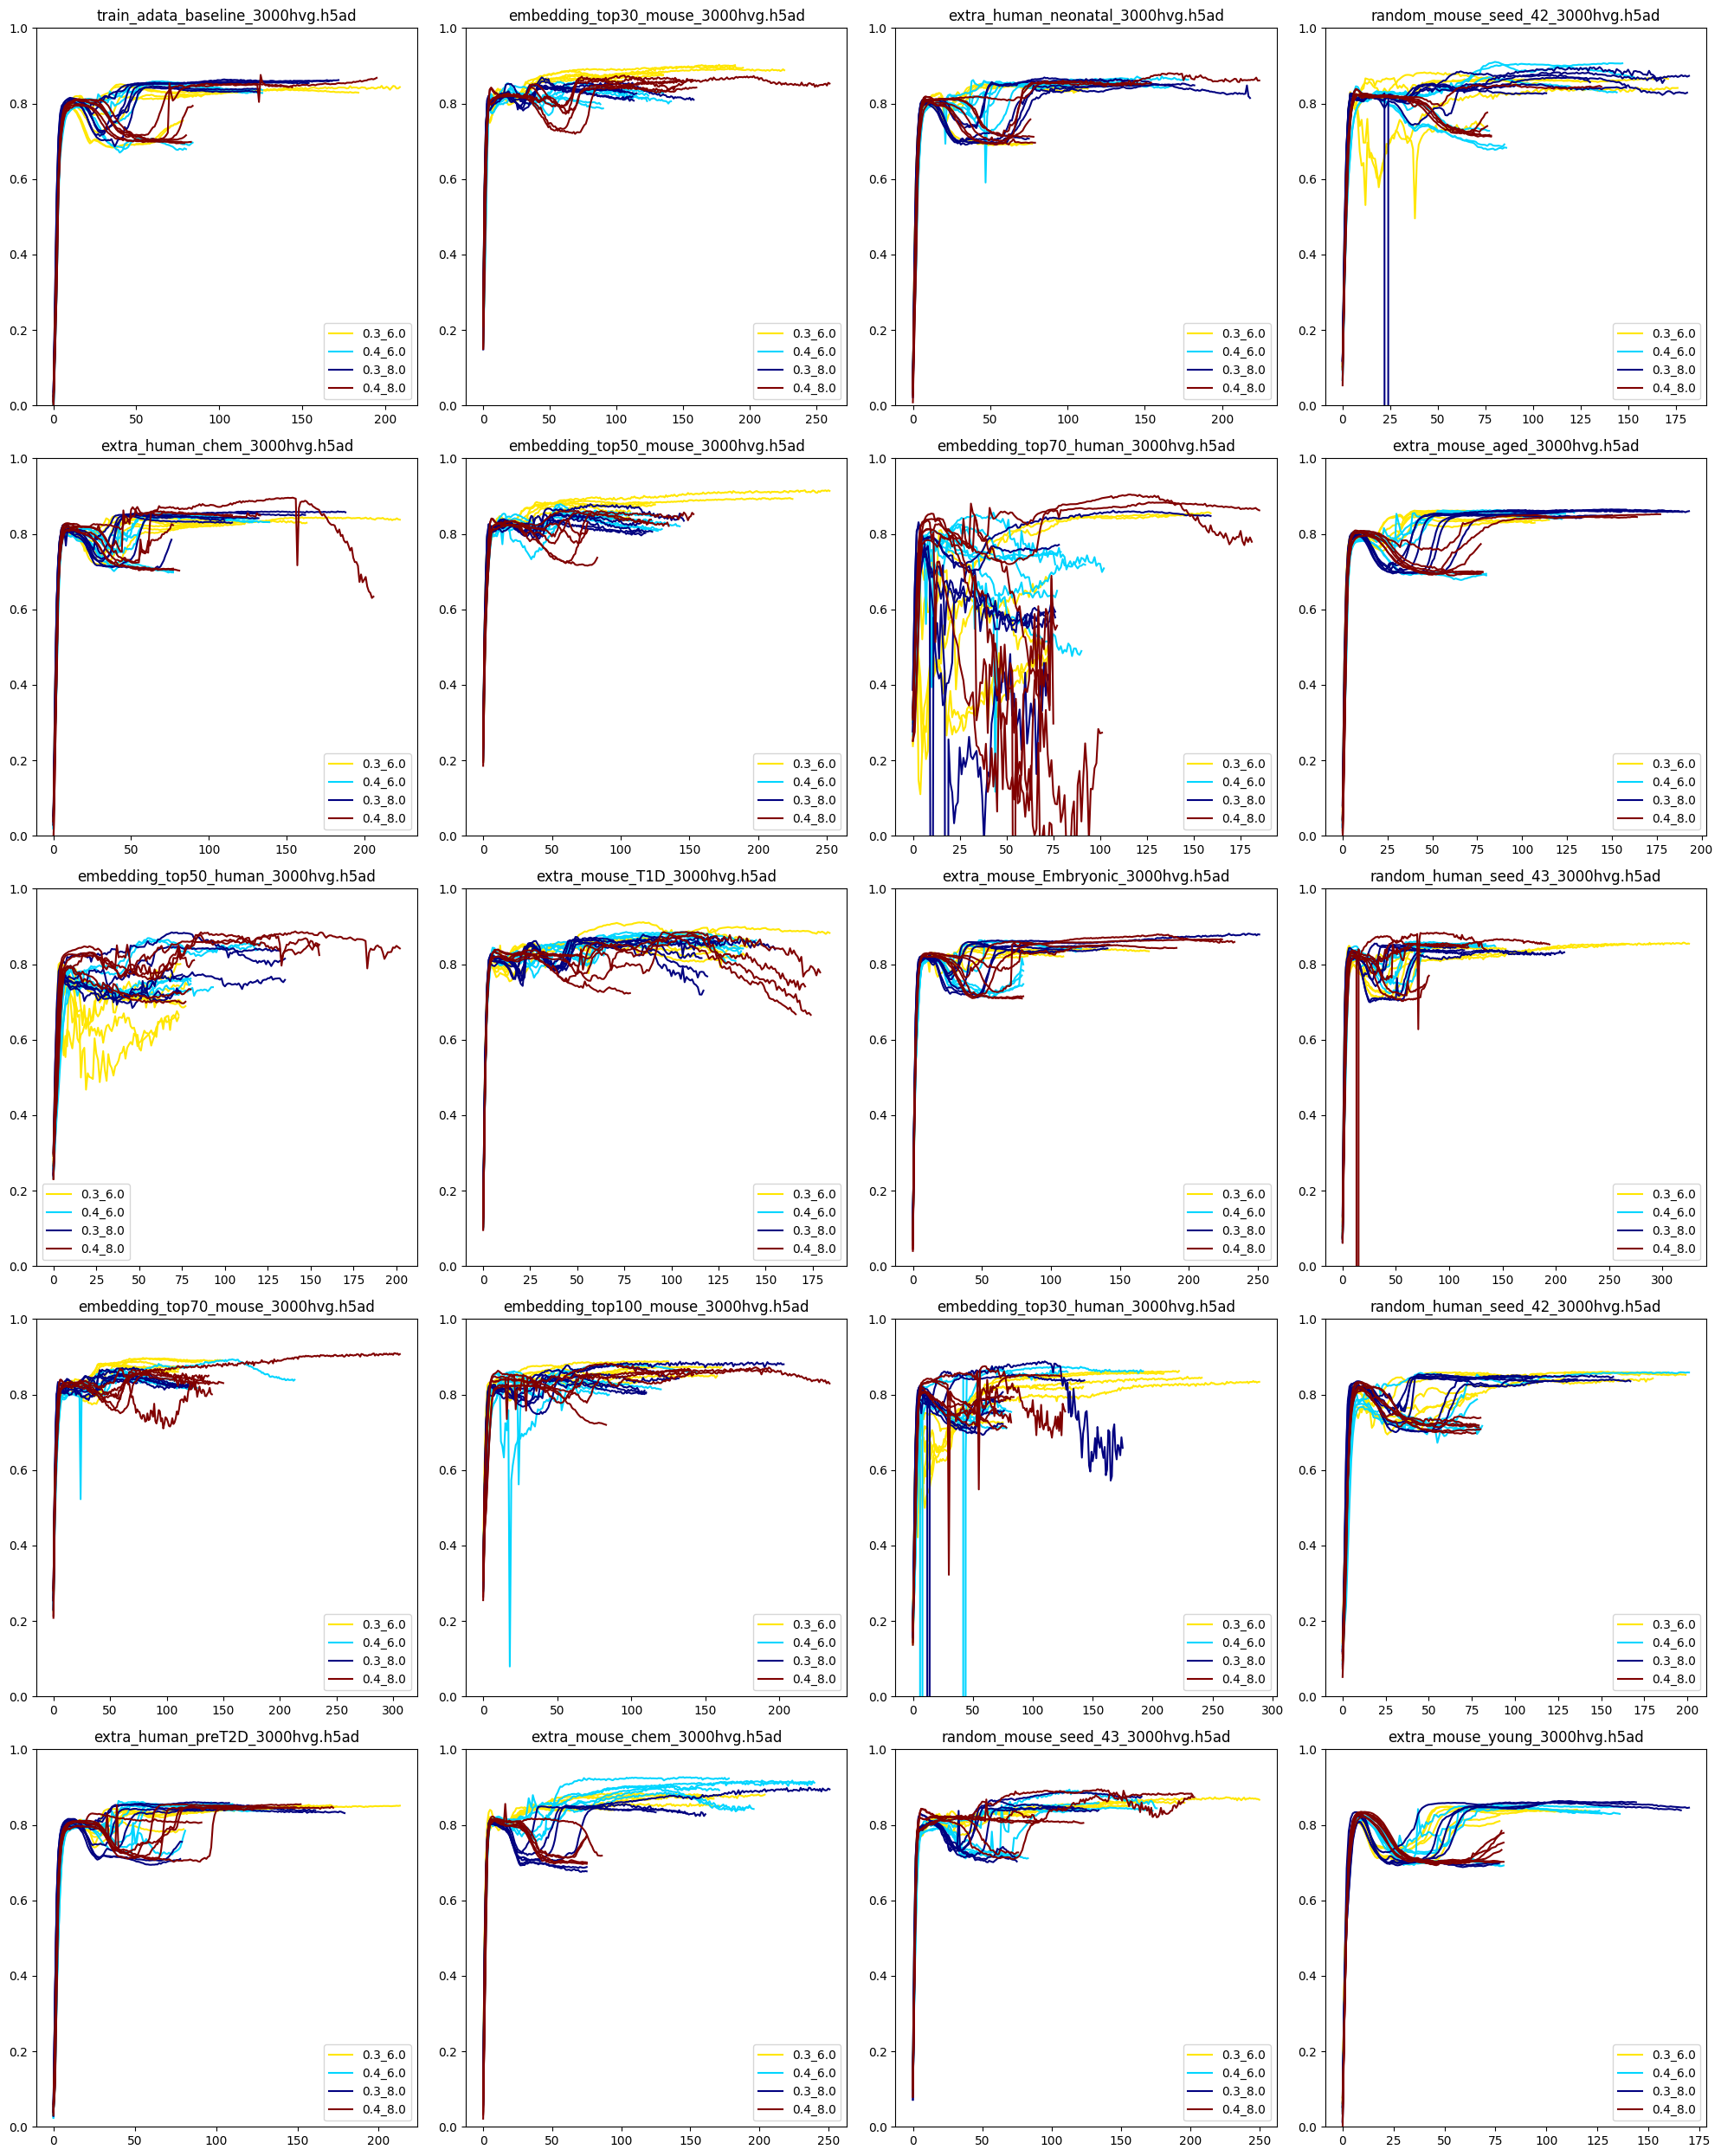

In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

param1 = "config.dropout_rate"
param2 = "config.n_layers"
metric = "result.mean_r2_validation_eval"

save_dict = dict()
metric_df = metric.split(".")[1]

for dataset in results["config.addl_dataset_train"].unique():
    save_tmp_dict = dict()
    max_length = 0  # Variable to keep track of the max length of lists for the current dataset
    tmp_df = results[results["config.addl_dataset_train"] == dataset]
    
    # First pass to find the max_length
    for i, row in tmp_df.iterrows():
        length = len(row[metric][metric_df])
        if length > max_length:
            max_length = length
    
    # Second pass to collect and pad data
    for i, row in tmp_df.iterrows():
        combined_key = f"{row[param1]}_{row[param2]}_{i}"
        padded_list = [float(elm) for elm in row[metric][metric_df]] + [np.nan]*(max_length - len(row[metric][metric_df]))
        save_tmp_dict[combined_key] = padded_list

    # Now all lists in save_tmp_dict have the same length
    save_dict[dataset] = save_tmp_dict


# Extract unique parameter combinations and create a colormap for them
combined_params = [(row[param1], row[param2]) for _, row in results.iterrows()]
unique_params = list(set(combined_params))  # get unique combinations
colors = plt.cm.jet(np.linspace(0, 1, len(unique_params)))
color_map = dict(zip(unique_params, colors))

# Setup 5x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.ravel()  # Flatten the 5x4 array for easier iteration

# Loop through all datasets and plot them
for idx, dataset_key in enumerate(save_dict.keys()):
    df = pd.DataFrame(save_dict[dataset_key])

    plotted_params = set()
    for column in df.columns:
        values = column.rsplit("_", 1)[0]  # Extracting the combined parameter values from the column name
        if values not in plotted_params:
            param_values = tuple(map(float, values.split("_")))
            df[column].plot(ax=axes[idx], color=color_map[param_values], label=f'{param_values[0]}_{param_values[1]}')
            plotted_params.add(values)
        else:
            df[column].plot(ax=axes[idx], color=color_map[param_values], label='_nolegend_')

    # Set the title and limit for each subplot
    axes[idx].set_title(dataset_key)
    axes[idx].set_ylim([0, 1])
    axes[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("fig_021123/meanR2_validation_per_dataset_colored_by_dr_o_rate_n_layers.png")
plt.show()


In [224]:
results_old = seml.get_results('transVAE_251023_redone', to_data_frame=True)

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

In [226]:
concat_df = pd.concat([results, results_old])

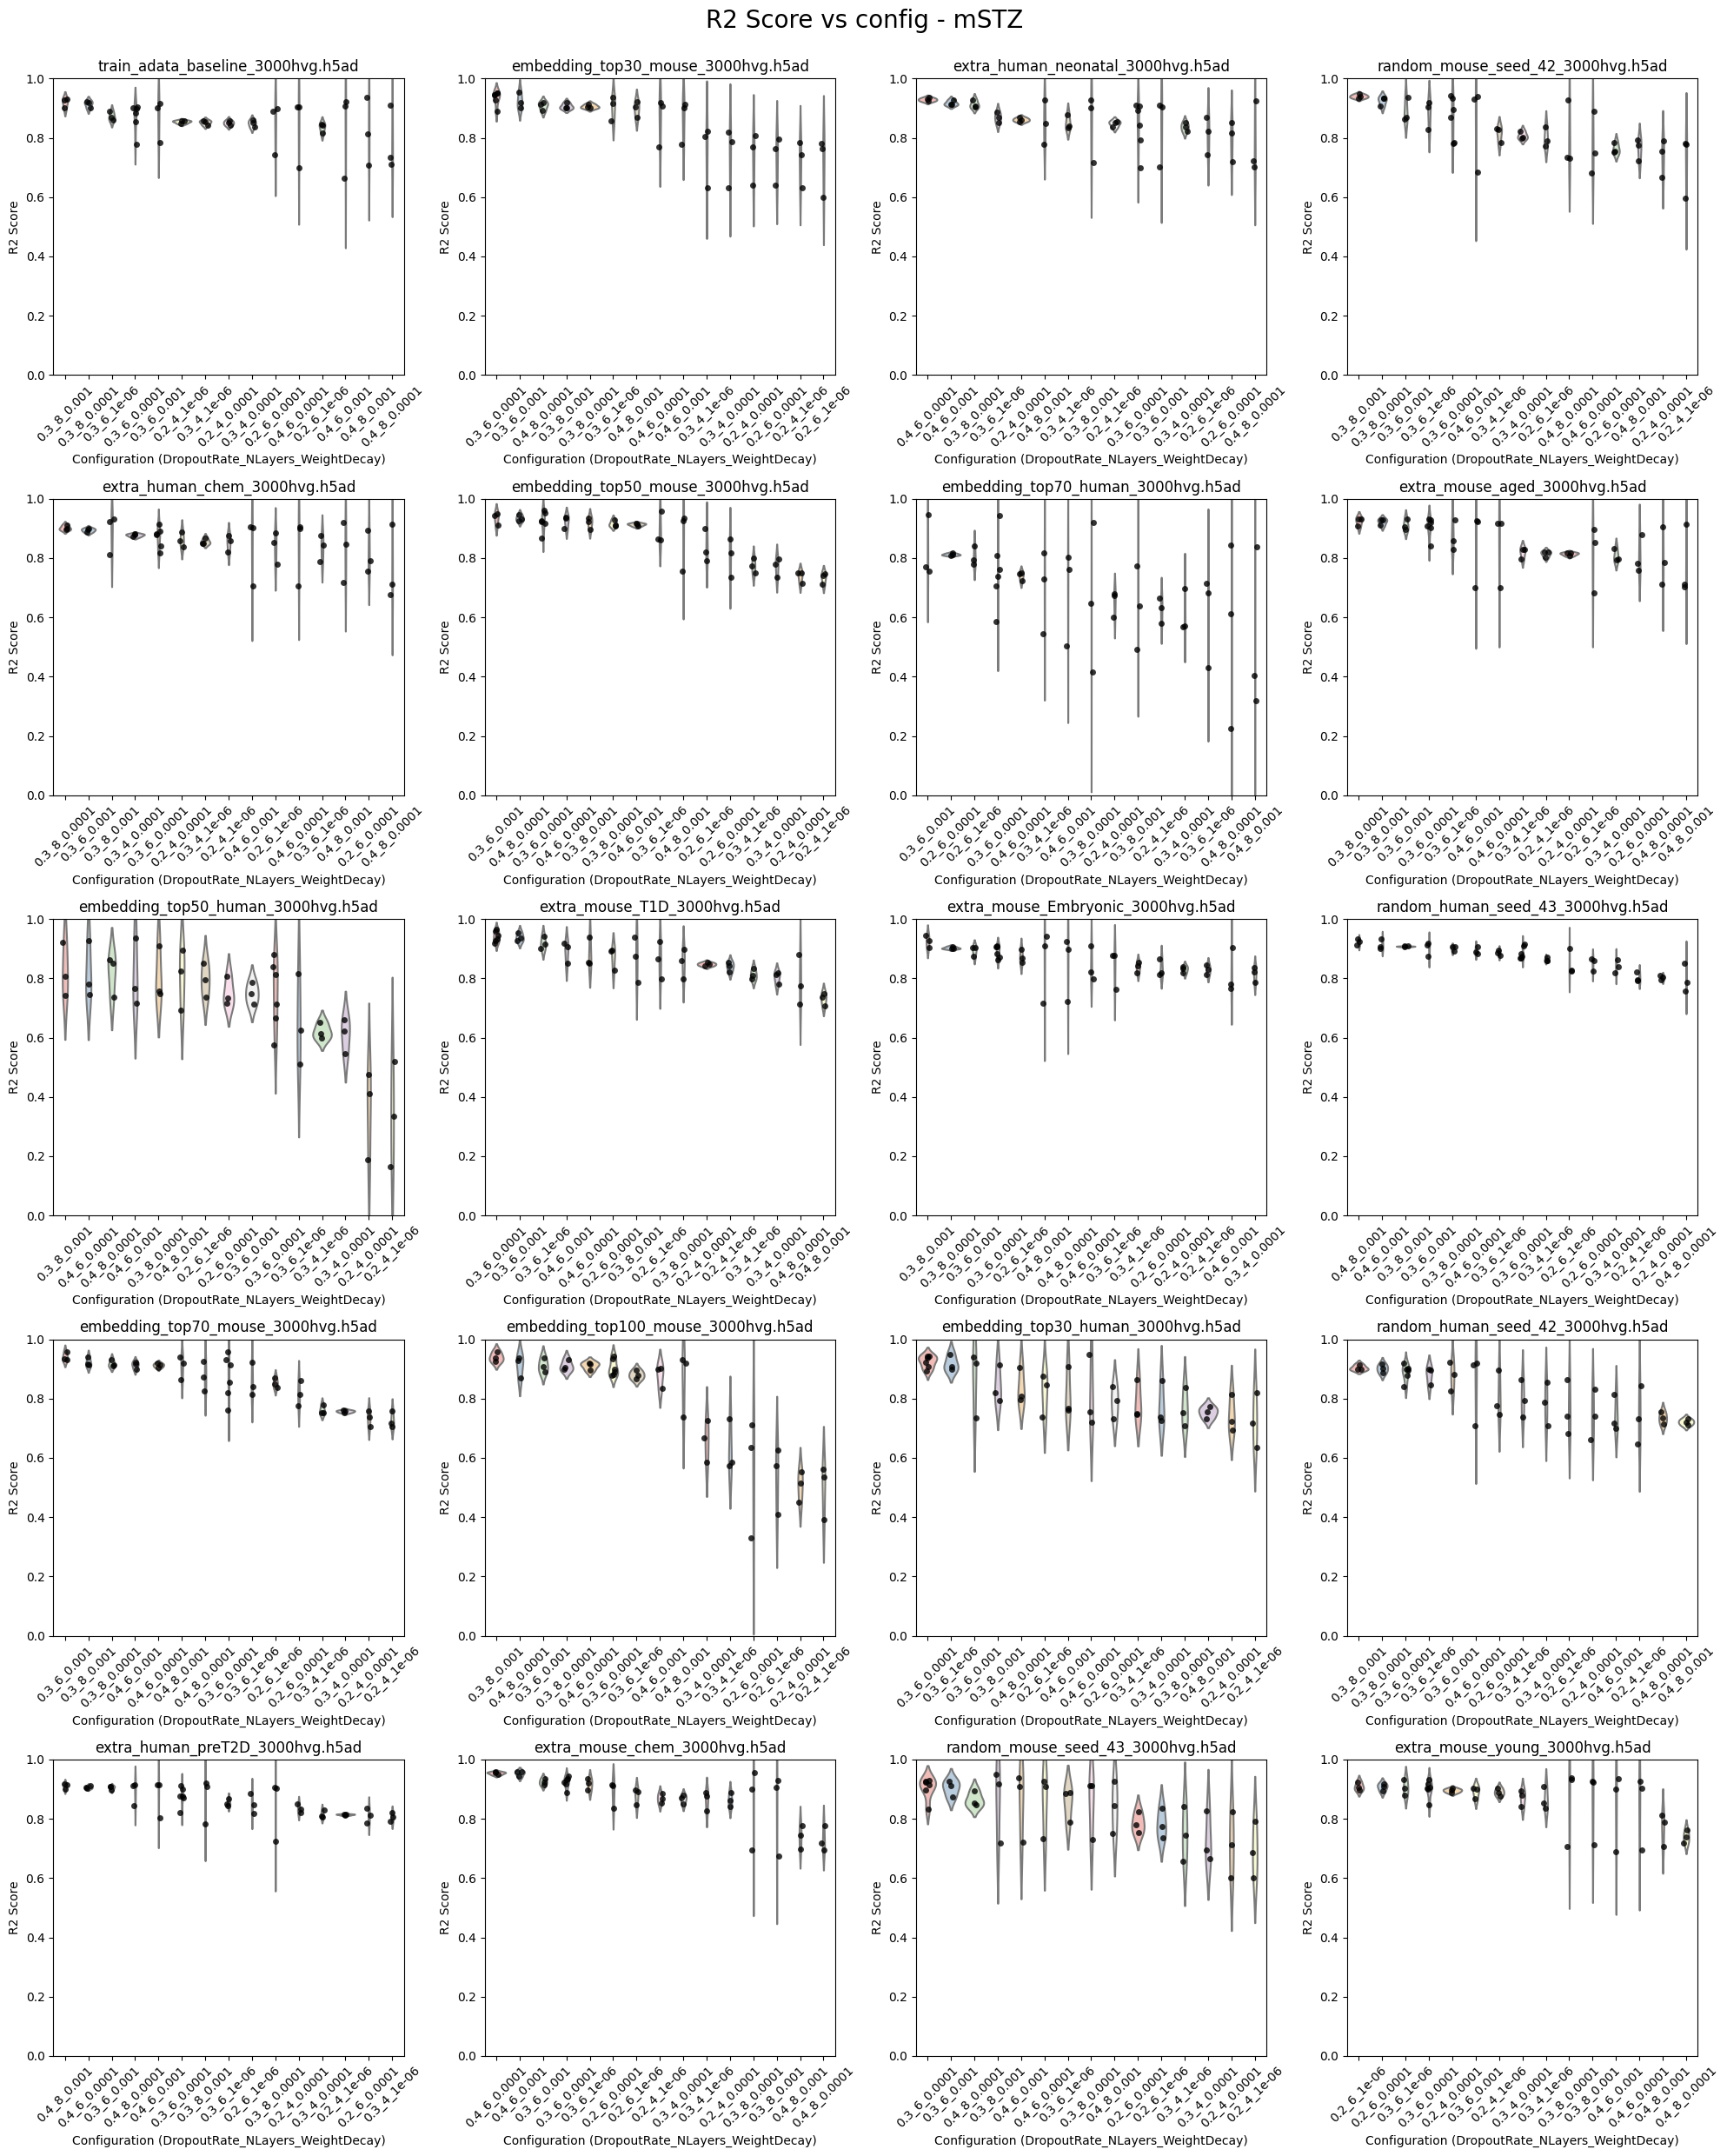

In [242]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

OOD_dataset = "mSTZ"

# Assuming 'results' is a pandas DataFrame with the necessary data
# Create a new column that combines the settings of weight decay and n_layers for grouping
concat_df['group'] = concat_df.apply(lambda row: f"{row['config.dropout_rate']}_{row['config.n_layers']}_{row['config.weight_decay']}", axis=1)

# Find the unique datasets to create subplots
unique_datasets = results['config.addl_dataset_train'].unique()

# Setup 5x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.ravel()  # Flatten the 5x4 array for easier iteration

# Iterate over each subplot and plot the data
for i, dataset in enumerate(unique_datasets):
    ax = axes[i]
    dataset_results = concat_df[concat_df['config.addl_dataset_train'] == dataset]

    # Calculate the mean R2 score for each group within the current dataset and sort the dataframe by these means
    group_means = dataset_results.groupby('group')[f'result.r2_{OOD_dataset}_OOD'].mean().reset_index()
    sorted_groups = group_means.sort_values(f'result.r2_{OOD_dataset}_OOD', ascending=False)['group']
    sorted_dataset_results = dataset_results.set_index('group').loc[sorted_groups].reset_index()
    
    sns.stripplot(
        x='group',
        y=f'result.r2_{OOD_dataset}_OOD',
        data=sorted_dataset_results,
        jitter=True,
        color='black',
        ax=ax,
        alpha=0.8,
    )
    
    # Set plot details
    ax.set_title(dataset)
    ax.set_xlabel('Configuration (DropoutRate_NLayers_WeightDecay)')
    ax.set_ylabel('R2 Score')
    ax.set_ylim([0, 1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels for better readability

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout to prevent overlap
plt.suptitle(f"R2 Score vs config - {OOD_dataset}", fontsize=20, y=0.99)  # Increase the fontsize as needed and adjust y for the position
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust the rect parameters as needed
plt.savefig(f"./fig_021123_R2_score_vs_config_{OOD_dataset}")

# Show the plot
plt.show()


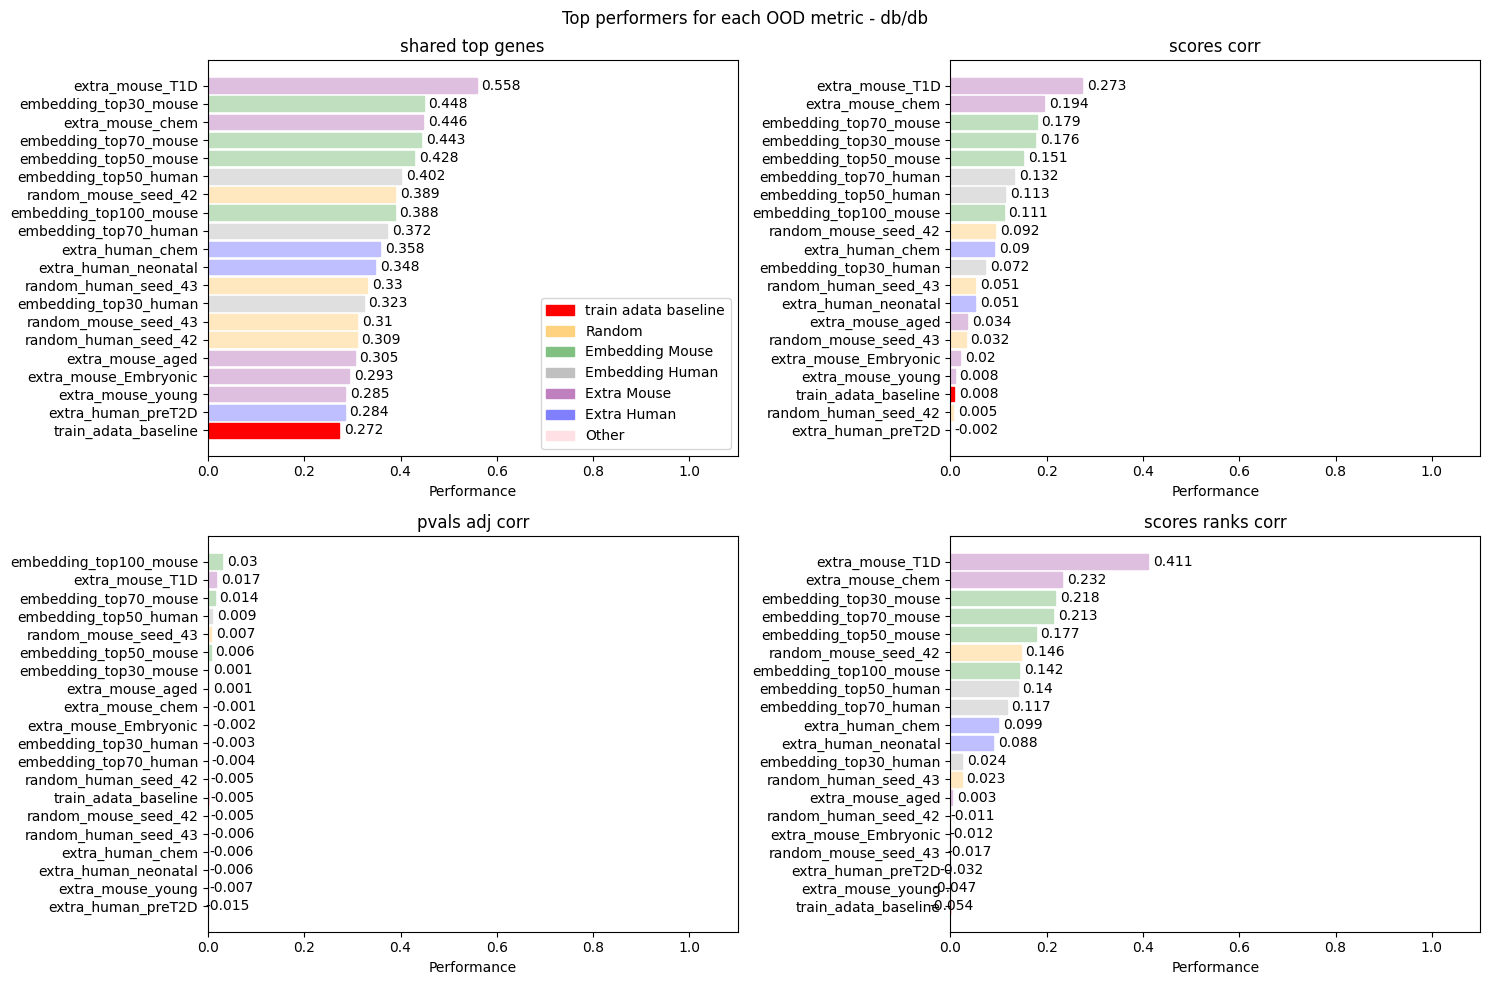

In [7]:
import matplotlib.pyplot as plt

top_performers = {}

tested_data = ['result.shared_top_genes_dbdb', 'result.scores_corr_dbdb', 'result.pvals_adj_corr_dbdb', 'result.scores_ranks_corr_dbdb']

for column in tested_data:
    top_performers[column] = []
    for dataset in groups_mean["config.addl_dataset_train"].unique():
        tmp_results = groups_mean[groups_mean["config.addl_dataset_train"] == dataset][column]
        top_row = tmp_results.nlargest(1)
        top_index = top_row.index[0]
        top_value = top_row.values[0]
        
        top_performers[column].append((dataset, top_value))

    top_performers[column].sort(key=lambda x: x[1], reverse=False)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patches as mpatches

# Assuming top_performers is your original dict of datasets

# Define base colors for each group
base_colors = {
    'random': 'orange',
    'embedding_mouse': 'green',
    'embedding_human': 'grey',
    'extra_mouse': 'purple',
    'extra_human': 'blue',
    'other': 'pink',  # For datasets that don't fit into the above categories
}

# Helper function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = np.array(mcolors.to_rgb(c))
    return mcolors.to_hex((1 - amount) * c + amount * np.array([1, 1, 1]))

# Create a color map for all possible labels in the top_performers dict
color_map = {}
for performers in top_performers.values():
    for name, _ in performers:
        short_name = name.replace('_3000hvg.h5ad', '')
        if 'random' in short_name:
            group_color = 'random'
        elif 'embedding' in short_name and 'mouse' in short_name:
            group_color = 'embedding_mouse'
        elif 'embedding' in short_name and 'human' in short_name:
            group_color = 'embedding_human'
        elif 'extra' in short_name and 'human' in short_name:
            group_color = 'extra_human'
        elif 'extra' in short_name and 'mouse' in short_name:
            group_color = 'extra_mouse'
        else:
            group_color = 'other'
        color_map[short_name] = lighten_color(base_colors[group_color], amount=0.75)

# Explicitly color 'train_adata_baseline' in red
color_map['train_adata_baseline'] = 'red'

# Use the dictionary to create a legend
legend_handles = [
    mpatches.Patch(color=color_map['train_adata_baseline'], label='train adata baseline'),
    mpatches.Patch(color=lighten_color(base_colors['random']), label='Random'),
    mpatches.Patch(color=lighten_color(base_colors['embedding_mouse']), label='Embedding Mouse'),
    mpatches.Patch(color=lighten_color(base_colors['embedding_human']), label='Embedding Human'),
    mpatches.Patch(color=lighten_color(base_colors['extra_mouse']), label='Extra Mouse'),
    mpatches.Patch(color=lighten_color(base_colors['extra_human']), label='Extra Human'),
    mpatches.Patch(color=lighten_color(base_colors['other']), label='Other'),
]

# Plotting in one figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes_flat = axes.flatten()

for ax, (column, performers) in zip(axes_flat, top_performers.items()):
    labels, values = zip(*performers)
    cleaned_labels = [label.replace('_3000hvg.h5ad', '') for label in labels]
    col_name = column.split(".")[1]
    col_name = " ".join(col_name.split("_")[:-1])
    
    # Create horizontal bars
    bars = ax.barh(cleaned_labels, values)

    # Color the bars using the color map
    for bar, label in zip(bars, cleaned_labels):
        bar.set_color(color_map[label])

    ax.set_title(col_name)
    ax.set_xlabel('Performance')
    ax.set_yticks(range(len(cleaned_labels)))
    ax.set_yticklabels(cleaned_labels)

    ax.set_xlim([0, 1.1])  # Adjust the x-axis limit to fit your data

    # Adding values on the side of the bars
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval + 0.01, bar.get_y() + bar.get_height() / 2, round(xval, 3), va='center')

# Add the legend to the last subplot for clarity
axes_flat[0].legend(handles=legend_handles, loc='lower right')

plt.suptitle('Top performers for each OOD metric - db/db') 
plt.tight_layout()
plt.savefig("./fig_021123//OOD_metrics_dbdb.png")
plt.show()


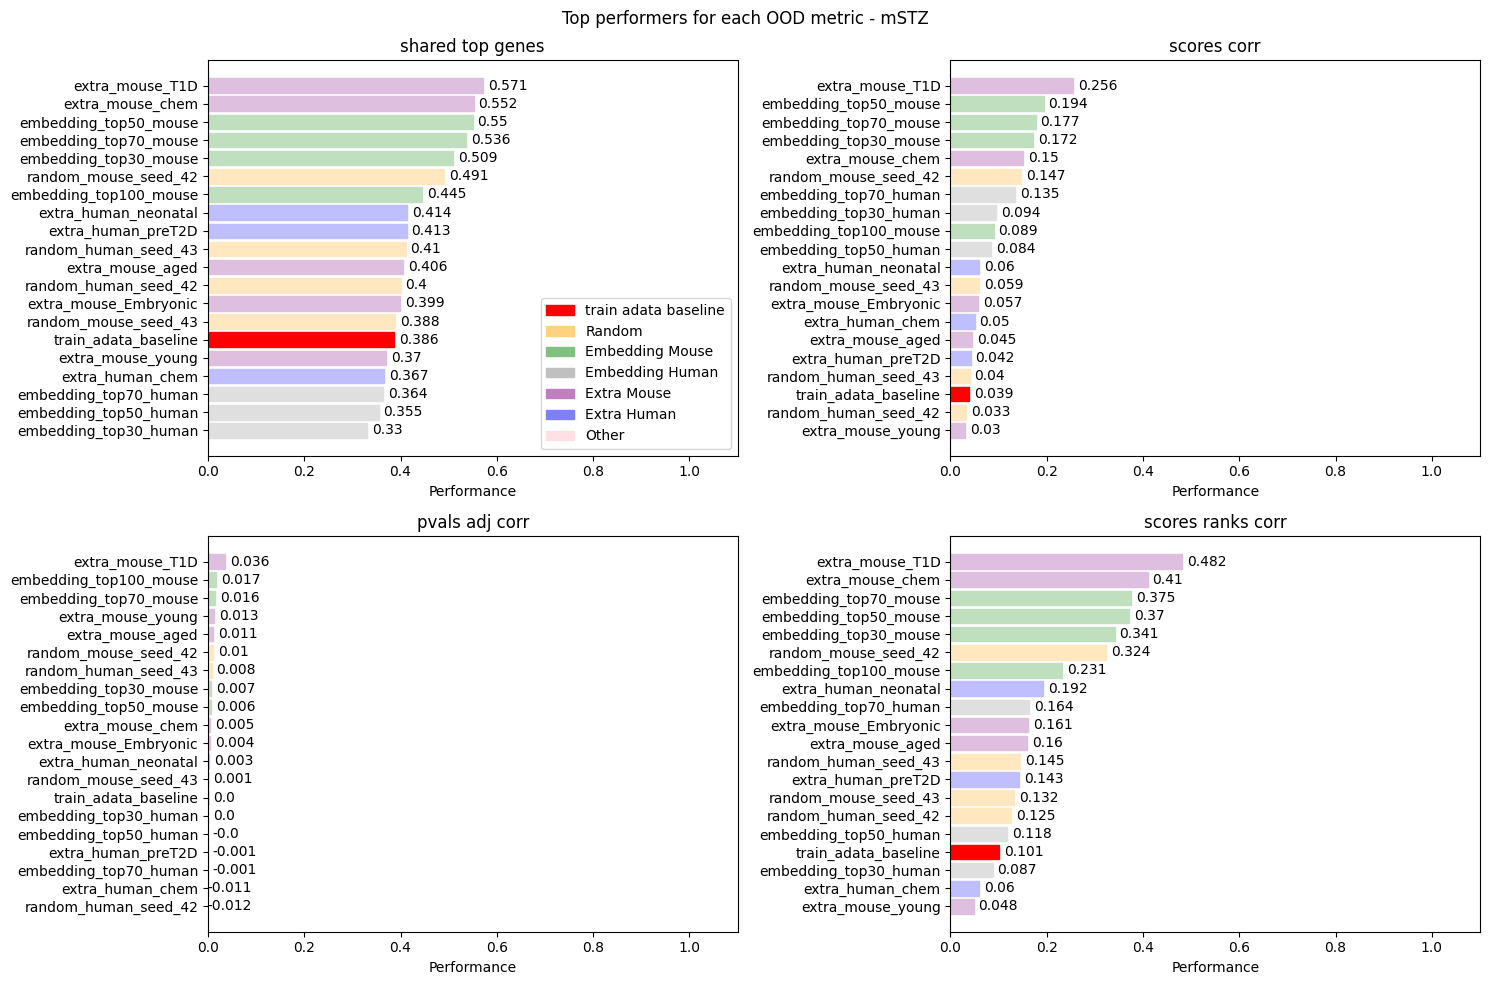

In [217]:
import matplotlib.pyplot as plt

top_performers = {}

tested_data = ['result.shared_top_genes_mSTZ', 'result.scores_corr_mSTZ', 'result.pvals_adj_corr_mSTZ', 'result.scores_ranks_corr_mSTZ']

for column in tested_data:
    top_performers[column] = []
    for dataset in groups_mean["config.addl_dataset_train"].unique():
        tmp_results = groups_mean[groups_mean["config.addl_dataset_train"] == dataset][column]
        top_row = tmp_results.nlargest(1)
        top_index = top_row.index[0]
        top_value = top_row.values[0]
        
        top_performers[column].append((dataset, top_value))

    top_performers[column].sort(key=lambda x: x[1], reverse=False)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patches as mpatches

# Assuming top_performers is your original dict of datasets

# Define base colors for each group
base_colors = {
    'random': 'orange',
    'embedding_mouse': 'green',
    'embedding_human': 'grey',
    'extra_mouse': 'purple',
    'extra_human': 'blue',
    'other': 'pink',  # For datasets that don't fit into the above categories
}

# Helper function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = np.array(mcolors.to_rgb(c))
    return mcolors.to_hex((1 - amount) * c + amount * np.array([1, 1, 1]))

# Create a color map for all possible labels in the top_performers dict
color_map = {}
for performers in top_performers.values():
    for name, _ in performers:
        short_name = name.replace('_3000hvg.h5ad', '')
        if 'random' in short_name:
            group_color = 'random'
        elif 'embedding' in short_name and 'mouse' in short_name:
            group_color = 'embedding_mouse'
        elif 'embedding' in short_name and 'human' in short_name:
            group_color = 'embedding_human'
        elif 'extra' in short_name and 'human' in short_name:
            group_color = 'extra_human'
        elif 'extra' in short_name and 'mouse' in short_name:
            group_color = 'extra_mouse'
        else:
            group_color = 'other'
        color_map[short_name] = lighten_color(base_colors[group_color], amount=0.75)

# Explicitly color 'train_adata_baseline' in red
color_map['train_adata_baseline'] = 'red'

# Use the dictionary to create a legend
legend_handles = [
    mpatches.Patch(color=color_map['train_adata_baseline'], label='train adata baseline'),
    mpatches.Patch(color=lighten_color(base_colors['random']), label='Random'),
    mpatches.Patch(color=lighten_color(base_colors['embedding_mouse']), label='Embedding Mouse'),
    mpatches.Patch(color=lighten_color(base_colors['embedding_human']), label='Embedding Human'),
    mpatches.Patch(color=lighten_color(base_colors['extra_mouse']), label='Extra Mouse'),
    mpatches.Patch(color=lighten_color(base_colors['extra_human']), label='Extra Human'),
    mpatches.Patch(color=lighten_color(base_colors['other']), label='Other'),
]

# Plotting in one figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes_flat = axes.flatten()

for ax, (column, performers) in zip(axes_flat, top_performers.items()):
    labels, values = zip(*performers)
    cleaned_labels = [label.replace('_3000hvg.h5ad', '') for label in labels]
    col_name = column.split(".")[1]
    col_name = " ".join(col_name.split("_")[:-1])
    
    # Create horizontal bars
    bars = ax.barh(cleaned_labels, values)

    # Color the bars using the color map
    for bar, label in zip(bars, cleaned_labels):
        bar.set_color(color_map[label])

    ax.set_title(col_name)
    ax.set_xlabel('Performance')
    ax.set_yticks(range(len(cleaned_labels)))
    ax.set_yticklabels(cleaned_labels)

    ax.set_xlim([0, 1.1])  # Adjust the x-axis limit to fit your data

    # Adding values on the side of the bars
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval + 0.01, bar.get_y() + bar.get_height() / 2, round(xval, 3), va='center')

# Add the legend to the last subplot for clarity
axes_flat[0].legend(handles=legend_handles, loc='lower right')

plt.suptitle('Top performers for each OOD metric - mSTZ') 
plt.tight_layout()
plt.savefig("./fig_021123/OOD_metrics_mSTZ.png")
plt.show()


In [8]:
top_rows = []
tested_data = ['result.shared_top_genes_dbdb']
for column in tested_data:  # 'tested_data' should be a list of column names you want to check.
    for dataset in groups_mean["config.addl_dataset_train"].unique():
        # Filter the rows where 'config.addl_dataset_train' equals the current 'dataset'
        tmp_results = groups_mean[groups_mean["config.addl_dataset_train"] == dataset]
        # Get the largest value's row for the current 'column'
        top_row = tmp_results.nlargest(1, column)  # 'nlargest' takes 'n' and the 'columns' arguments
        top_rows.append(top_row)  # Append this top row to the 'top_rows' list

# Concatenate all the top rows into a single DataFrame
top_rows_df = pd.concat(top_rows, ignore_index=True)  # 'ignore_index=True' to reindex the new DataFrame

In [66]:
import os
import numpy as np
import pandas as pd

top_preds_dbdb = {}
for index, row in top_rows_df.iterrows():
    save_folder_name = "regularisation_validation_eval_021123"  # replace with your actual save folder name if needed
    # Construct the directory path for the saved models
    save_dir = f"/d/hpc/projects/FRI/DL/mo6643/MSC/cross_species_prediction_save/{save_folder_name}"
    save_folder = f"transVAE_train_{row['config.addl_dataset_train']}_hid{row['config.n_hidden']}_lat{int(row['config.n_latent'])}_lr{row['config.learning_rate']}_cov{int(row['config.cov_embed_dims'])}_ep{int(row['config.max_epochs'])}_ly{row['config.n_layers']}_dr{row['config.dropout_rate']}_kl{row['config.kl_weight']}_wd{row['config.weight_decay']}_s{int(row['config.seed'])}"
    dir_path = os.path.join(save_dir, save_folder)
    
    addl_dataset = row["config.addl_dataset_train"].split(".")[0]
    
    # Load the prediction file if it exists
    pred_file = os.path.join(dir_path, "preds_dbdb_OOD.npy")
    if os.path.exists(pred_file):
        preds = np.load(pred_file)
        top_preds_dbdb[addl_dataset] = preds
    else:
        print(f"Prediction file not found for configuration: {save_folder}")

In [8]:
path = "/d/hpc/projects/FRI/DL/mo6643/MSC/cross_species_prediction_save/dbdb_ground_truth_OOD.npy"
gt = np.load(path)

In [9]:
from tqdm import tqdm
from scipy import stats
import numpy as np

def compute_wasserstein_distance(preds, gt):
    # Ensure that 'preds' and 'gt' are numpy arrays for efficient computation
    preds = np.asarray(preds)
    gt = np.asarray(gt)

    # Preallocate the distances array with the correct length
    distances = np.zeros(preds.shape[1])

    # Use tqdm to create a progress bar for the loop
    for gene in tqdm(range(preds.shape[1]), desc="Computing Wasserstein distances"):
        # Compute the Wasserstein distance and assign it directly to the distances array
        distances[gene] = stats.wasserstein_distance(preds[:, gene], gt[:, gene])

    return distances


In [14]:
wasserstein_distances = {}
num_datasets = len(top_preds_dbdb.keys())
dataset = 1
for addl_dataset_name, preds in top_preds_dbdb.items():
    print(f"{dataset}/{num_datasets} computing: {addl_dataset_name}")
    distance = compute_wasserstein_distance(preds, gt)
    wasserstein_distances[addl_dataset_name] = distance
    dataset += 1

1/20 computing: embedding_top100_mouse_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:39<00:00, 75.69it/s]


2/20 computing: embedding_top30_human_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:40<00:00, 73.36it/s]


3/20 computing: embedding_top30_mouse_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:39<00:00, 75.02it/s]


4/20 computing: embedding_top50_human_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:39<00:00, 75.84it/s]


5/20 computing: embedding_top50_mouse_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:37<00:00, 79.34it/s]


6/20 computing: embedding_top70_human_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:40<00:00, 74.42it/s]


7/20 computing: embedding_top70_mouse_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:36<00:00, 81.42it/s]


8/20 computing: extra_human_chem_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:35<00:00, 84.29it/s]


9/20 computing: extra_human_neonatal_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:38<00:00, 77.84it/s]


10/20 computing: extra_human_preT2D_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:38<00:00, 78.04it/s]


11/20 computing: extra_mouse_Embryonic_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:36<00:00, 81.57it/s]


12/20 computing: extra_mouse_T1D_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:40<00:00, 74.65it/s]


13/20 computing: extra_mouse_aged_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:39<00:00, 75.44it/s]


14/20 computing: extra_mouse_chem_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:39<00:00, 76.75it/s]


15/20 computing: extra_mouse_young_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:36<00:00, 81.43it/s]


16/20 computing: random_human_seed_42_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:37<00:00, 80.44it/s]


17/20 computing: random_human_seed_43_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:37<00:00, 80.77it/s]


18/20 computing: random_mouse_seed_42_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:36<00:00, 81.53it/s]


19/20 computing: random_mouse_seed_43_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:36<00:00, 81.44it/s]


20/20 computing: train_adata_baseline_3000hvg


Computing Wasserstein distances: 100%|██████████| 3000/3000 [00:36<00:00, 81.54it/s]


In [ ]:
df = pd.DataFrame(wasserstein_distances)
df.to_csv("./results/wasserstein_distance_021123.csv")

In [ ]:
# The column to subtract from all others
baseline_col = 'train_adata_baseline_3000hvg'

# Subtract the baseline column from every other column
# Use df.sub(df[baseline_col], axis=0) to broadcast subtraction across the correct axis (rows)
df_adjusted = df.sub(df[baseline_col], axis=0)

# Now, 'df_adjusted' has the baseline column values subtracted from all other columns
# However, the 'baseline_col' itself will be all zeros after this operation, so you may want to drop or ignore it
df_adjusted.drop(columns=baseline_col, inplace=True)

df_adjusted  # This DataFrame now has the adjusted values

In [ ]:
import matplotlib.pyplot as plt

# Assuming `df` is your pandas DataFrame with the columns you want to plot
# Create a figure with subplots in a 5x4 grid (or another configuration that suits your preference)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15)) # Adjust the size as necessary

# Flatten the array of axes to easily iterate over it
axes = axes.flatten()

# Loop over all the columns and their corresponding axes to plot histograms
for i, column in enumerate(df_adjusted.columns):
    # Plot histogram on the ith axes
    axes[i].hist(df_adjusted[column], bins=20, alpha=0.5) # Adjust the number of bins as you see fit
    axes[i].set_title(column)
    axes[i].set_ylabel('Frequency')
    # Set tight layout
    plt.tight_layout()
    plt.xlim([-1.5, 1.5])

# Hide any empty subplots that aren't used (if your number of columns is not a multiple of the grid size)
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.show()


In [ ]:
import scanpy as sc

In [ ]:
adata = sc.read_h5ad("/d/hpc/projects/FRI/DL/mo6643/MSC/data/data_update_slack/data_splits/data_splits_train_merge/train_data/train_adata_baseline_3000hvg.h5ad")

In [ ]:
df_adjusted.index = adata.var.index

In [ ]:
df_adjusted.sort_values("extra_mouse_T1D_3000hvg", ascending=True)

In [149]:
!pip install biomart

In [150]:
from biomart import BiomartServer

In [154]:
server = BiomartServer("http://www.ensembl.org/biomart")

In [157]:
ensembl = server.datasets['mmusculus_gene_ensembl']

In [169]:
from biomart import BiomartServer

def get_gene_descriptions(gene_ids):
    print("Setting up ensembl server")
    # Connect to the Ensembl BioMart server
    server = BiomartServer("http://www.ensembl.org/biomart")

    # Select the database and dataset to use (for example, the hsapiens_gene_ensembl for human genes)
    ensembl = server.datasets['mmusculus_gene_ensembl']
    
    print("Searching enseml")
    
    # Execute the query
    response = ensembl.search({'filters': {'ensembl_gene_id': gene_ids},
                               'attributes': ['ensembl_gene_id', 'gene_biotype', 
                                              'external_gene_name', 'description']})
    
    # Parse the response into a readable format, e.g., a list of dictionaries
    results = []
    for line in response.iter_lines():
        line = line.decode('utf-8')  # Decode the byte string into a normal string
        row = line.split("\t")       # Split the string into a list based on tab separation
        result = {
            'Ensembl Gene ID': row[0],
            'Gene Biotype': row[1],
            'External Gene Name': row[2],
            'Description': row[3] if len(row) > 3 else ""  # Check if description is available
        }
        results.append(result)
    print("Done")
        
    return results

In [170]:
topN = 20
gene_ids = df_adjusted.sort_values("extra_mouse_T1D_3000hvg", ascending=True).head(topN).index.tolist()
gene_descriptions = get_gene_descriptions(gene_ids)

Setting up ensembl server
Searching enseml
Done


In [173]:
gene_descriptions = pd.DataFrame(gene_descriptions)

In [177]:
top_20_genes = df_adjusted.sort_values("extra_mouse_T1D_3000hvg", ascending=True).head(topN).index.tolist()

In [181]:
df_adjusted_top20 = df_adjusted[df_adjusted.index.isin(top_20_genes)]

In [182]:
gene_descriptions.columns

Index(['Ensembl Gene ID', 'Gene Biotype', 'External Gene Name', 'Description'], dtype='object')

In [184]:
df_adjusted_top20 = df_adjusted_top20.merge(gene_descriptions, right_on = "Ensembl Gene ID", left_index=True)

In [186]:
df_adjusted_top20 = df_adjusted_top20.sort_values("extra_mouse_T1D_3000hvg")

In [ ]:
df_adjusted_top20

In [185]:
pd.DataFrame(df_adjusted_top20).to_csv(f"top{topN}_improved_genes.csv")

In [193]:
df_adjusted.columns

Index(['embedding_top100_mouse_3000hvg', 'embedding_top30_human_3000hvg',
       'embedding_top30_mouse_3000hvg', 'embedding_top50_human_3000hvg',
       'embedding_top50_mouse_3000hvg', 'embedding_top70_human_3000hvg',
       'embedding_top70_mouse_3000hvg', 'extra_human_chem_3000hvg',
       'extra_human_neonatal_3000hvg', 'extra_human_preT2D_3000hvg',
       'extra_mouse_Embryonic_3000hvg', 'extra_mouse_T1D_3000hvg',
       'extra_mouse_aged_3000hvg', 'extra_mouse_chem_3000hvg',
       'extra_mouse_young_3000hvg', 'random_human_seed_42_3000hvg',
       'random_human_seed_43_3000hvg', 'random_mouse_seed_42_3000hvg',
       'random_mouse_seed_43_3000hvg'],
      dtype='object')

In [ ]:
top_n_shared = 100

In [210]:
def find_shared_genes_proportion(df, top_n_shared, columns_to_compare=None):
    # If no specific columns are provided, compare all columns
    if columns_to_compare is None:
        columns_to_compare = df.columns

    # A list to store sets of top N genes for each specified column
    top_genes_sets = []

    # Iterate over the specified columns, sort by each, and get the top N genes
    for column in columns_to_compare:
        top_genes = set(df.sort_values(by=column, ascending=False).head(top_n_shared).index)
        top_genes_sets.append(top_genes)

    # Find the intersection of all sets
    shared_genes = set.intersection(*top_genes_sets)

    # Calculate the proportion of shared genes
    # Since we are assuming all columns have the same number of top N genes,
    # the total unique genes would be the sum of top N genes across all compared columns
    # minus the shared genes that are counted multiple times in the intersection.
    total_genes = top_n_shared * len(columns_to_compare)  # Total genes if there were no overlap
    proportion_shared = len(shared_genes) / total_genes if total_genes > 0 else 0

    return proportion_shared, shared_genes


In [211]:
df_adjusted.columns

Index(['embedding_top100_mouse_3000hvg', 'embedding_top30_human_3000hvg',
       'embedding_top30_mouse_3000hvg', 'embedding_top50_human_3000hvg',
       'embedding_top50_mouse_3000hvg', 'embedding_top70_human_3000hvg',
       'embedding_top70_mouse_3000hvg', 'extra_human_chem_3000hvg',
       'extra_human_neonatal_3000hvg', 'extra_human_preT2D_3000hvg',
       'extra_mouse_Embryonic_3000hvg', 'extra_mouse_T1D_3000hvg',
       'extra_mouse_aged_3000hvg', 'extra_mouse_chem_3000hvg',
       'extra_mouse_young_3000hvg', 'random_human_seed_42_3000hvg',
       'random_human_seed_43_3000hvg', 'random_mouse_seed_42_3000hvg',
       'random_mouse_seed_43_3000hvg'],
      dtype='object')

In [214]:
# Example usage:
# df_adjusted is your dataframe and top_n_shared is the N top values you want to compare
top_n_shared = 100  # Replace with your actual value
proportion_shared, shared_genes = find_shared_genes_proportion(df_adjusted, top_n_shared, columns_to_compare=["extra_mouse_T1D_3000hvg", "embedding_top30_mouse_3000hvg"])
print("Proportion of shared genes:", proportion_shared)

Proportion of shared genes: 0.12


In [243]:
proportion_shared, shared_genes = find_shared_genes_proportion(df_adjusted, top_n_shared)
print("Proportion of shared genes:", proportion_shared)

Proportion of shared genes: 0.0005263157894736842


## Checking negative predictions (how much they imact metrics)

In [13]:
import scanpy as sc

In [237]:
top_rows = []
tested_data = ['result.shared_top_genes_dbdb']
for column in tested_data:  # 'tested_data' should be a list of column names you want to check.
    for dataset in results["config.addl_dataset_train"].unique():
        # Filter the rows where 'config.addl_dataset_train' equals the current 'dataset'
        tmp_results = results[results["config.addl_dataset_train"] == dataset]
        # Get the largest value's row for the current 'column'
        top_row = tmp_results.nlargest(1, column)  # 'nlargest' takes 'n' and the 'columns' arguments
        top_rows.append(top_row)  # Append this top row to the 'top_rows' list

# Concatenate all the top rows into a single DataFrame
top_rows_df = pd.concat(top_rows, ignore_index=True)  # 'ignore_index=True' to reindex the new DataFrame

In [238]:
top_rows_df[['config.addl_dataset_train','result.shared_top_genes_dbdb', 'result.scores_corr_dbdb',
       'result.pvals_adj_corr_dbdb', 'result.scores_ranks_corr_dbdb','config.n_hidden', 'config.n_layers',
       'config.dropout_rate', 'config.weight_decay', '_id', 'config.overwrite',
       'config.cov_embed_dims', 'config.kl_weight', 'config.learning_rate',
       'config.max_epochs', 'config.n_latent', 'config.save_models',
       'config.seed', 'result.r2_dbdb_OOD']]

,config.addl_dataset_train,result.shared_top_genes_dbdb,result.scores_corr_dbdb,result.pvals_adj_corr_dbdb,result.scores_ranks_corr_dbdb,config.n_hidden,config.n_layers,config.dropout_rate,config.weight_decay,_id,config.overwrite,config.cov_embed_dims,config.kl_weight,config.learning_rate,config.max_epochs,config.n_latent,config.save_models,config.seed,result.r2_dbdb_OOD
0,train_adata_baseline_3000hvg.h5ad,0.306,0.065564,-0.043282,0.079043,1000,8,0.4,0.0010,24,24,10,0.005,0.0001,1500,512,True,44,0.798666
1,embedding_top30_mouse_3000hvg.h5ad,0.509,0.152306,0.001867,0.270792,1000,8,0.4,0.0010,47,47,10,0.005,0.0001,1500,512,True,43,0.820292
2,extra_human_neonatal_3000hvg.h5ad,0.475,0.166016,0.017157,0.334427,1000,8,0.4,0.0010,71,71,10,0.005,0.0001,1500,512,True,43,0.874594
3,random_mouse_seed_42_3000hvg.h5ad,0.524,0.194960,0.006484,0.382434,1000,6,0.3,0.0010,76,76,10,0.005,0.0001,1500,512,True,42,0.871508
4,extra_human_chem_3000hvg.h5ad,0.520,0.285370,0.003659,0.419436,1000,8,0.4,0.0001,117,117,10,0.005,0.0001,1500,512,True,44,0.589784
5,embedding_top50_mouse_3000hvg.h5ad,0.482,0.234474,-0.021425,0.271331,1000,6,0.3,0.0001,123,123,10,0.005,0.0001,1500,512,True,44,0.874887
6,embedding_top70_human_3000hvg.h5ad,0.519,0.300899,-0.018639,0.372852,1000,8,0.4,0.0001,164,164,10,0.005,0.0001,1500,512,True,43,0.713986
7,extra_mouse_aged_3000hvg.h5ad,0.336,0.040441,-0.019064,0.033248,1000,6,0.3,0.0010,174,174,10,0.005,0.0001,1500,512,True,44,0.773142
8,embedding_top50_human_3000hvg.h5ad,0.496,0.223252,0.034128,0.325248,1000,8,0.4,0.0010,216,216,10,0.005,0.0001,1500,512,True,44,0.807492
9,extra_mouse_T1D_3000hvg.h5ad,0.595,0.322983,0.000234,0.473066,1000,6,0.4,0.0001,224,224,10,0.005,0.0001,1500,512,True,43,0.815515


In [239]:
import os
import numpy as np
import pandas as pd

top_preds_dbdb = {}
for index, row in top_rows_df.iterrows():
    save_folder_name = "regularisation_validation_eval_021123"  # replace with your actual save folder name if needed
    # Construct the directory path for the saved models
    save_dir = f"/d/hpc/projects/FRI/DL/mo6643/MSC/cross_species_prediction_save/{save_folder_name}"
    save_folder = f"transVAE_train_{row['config.addl_dataset_train']}_hid{row['config.n_hidden']}_lat{int(row['config.n_latent'])}_lr{row['config.learning_rate']}_cov{int(row['config.cov_embed_dims'])}_ep{int(row['config.max_epochs'])}_ly{row['config.n_layers']}_dr{row['config.dropout_rate']}_kl{row['config.kl_weight']}_wd{row['config.weight_decay']}_s{int(row['config.seed'])}"
    dir_path = os.path.join(save_dir, save_folder)
    
    addl_dataset = row["config.addl_dataset_train"].split(".")[0]
    
    # Load the prediction file if it exists
    pred_file = os.path.join(dir_path, "preds_dbdb_OOD.npy")
    if os.path.exists(pred_file):
        preds = np.load(pred_file)
        top_preds_dbdb[addl_dataset] = preds
    else:
        print(f"Prediction file not found for configuration: {save_folder}")

In [240]:
dataset_ground_truth1 = "dbdb_ground_truth_3000hvg.h5ad"
dbdb_ground_truth = sc.read_h5ad(f"/d/hpc/projects/FRI/DL/mo6643/MSC/data/data_update_slack/data_splits/data_splits_train_merge/ground_truth/{dataset_ground_truth1}")

In [241]:
dbdb_ground_truth_h = dbdb_ground_truth[dbdb_ground_truth.obs.disease == "healthy"]
dbdb_ground_truth_OOD = dbdb_ground_truth[dbdb_ground_truth.obs.disease == "T2D"]

In [242]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc

def compare_de(X: np.ndarray, Y: np.ndarray, C: np.ndarray, shared_top: int = 100, **kwargs) -> dict:
    """Compare DEG across real and simulated perturbations.

    Computes DEG for real and simulated perturbations vs. control and calculates
    metrics to evaluate similarity of the results.

    Args:
        X: Real perturbed data.
        Y: Simulated perturbed data.
        C: Control data
        shared_top: The number of top DEG to compute the proportion of their intersection.
        **kwargs: arguments for `scanpy.tl.rank_genes_groups`.
    """
    
    n_vars = X.shape[1]
    assert n_vars == Y.shape[1] == C.shape[1]

    shared_top = min(shared_top, n_vars)
    vars_ranks = np.arange(1, n_vars + 1)

    adatas_xy = {}
    adatas_xy["x"] = ad.AnnData(X, obs={"label": "comp"})
    adatas_xy["y"] = ad.AnnData(Y, obs={"label": "comp"})
    adata_c = ad.AnnData(C, obs={"label": "ctrl"})

    results = pd.DataFrame(index=adata_c.var_names)
    top_names = []
    for group in ("x", "y"):
        adata_joint = ad.concat((adatas_xy[group], adata_c), index_unique="-")

        sc.tl.rank_genes_groups(adata_joint, groupby="label", reference="ctrl", key_added="de", **kwargs)

        srt_idx = np.argsort(adata_joint.uns["de"]["names"]["comp"])
        results[f"scores_{group}"] = adata_joint.uns["de"]["scores"]["comp"][srt_idx]
        results[f"pvals_adj_{group}"] = adata_joint.uns["de"]["pvals_adj"]["comp"][srt_idx]
        # needed to avoid checking rankby_abs
        results[f"ranks_{group}"] = vars_ranks[srt_idx]

        top_names.append(adata_joint.uns["de"]["names"]["comp"][:shared_top])

    metrics = {}
    metrics["shared_top_genes"] = len(set(top_names[0]).intersection(top_names[1])) / shared_top
    metrics["scores_corr"] = results["scores_x"].corr(results["scores_y"], method="pearson")
    metrics["pvals_adj_corr"] = results["pvals_adj_x"].corr(results["pvals_adj_y"], method="pearson")
    metrics["scores_ranks_corr"] = results["ranks_x"].corr(results["ranks_y"], method="spearman")

    return metrics

In [243]:
import warnings
warnings.filterwarnings("always")

In [244]:
X_cache = None
results = dict()
for dataset, X in top_preds_dbdb.items():
    tmp_dict = {}
    wo_zero_setting = compare_de(X=dbdb_ground_truth_OOD.X.toarray(), Y=X, C=dbdb_ground_truth_h.X.toarray(), shared_top = 1000)
    tmp_dict["top_shared_wo_zero_setting"] = wo_zero_setting["shared_top_genes"]
    # setting to 0
    if X_cache is not None:
        if (X == X_cache).all():
            raise ValueError("Matrices are the same.")
    X_cache = X
    X[X < 0] = 0
    zero_setting = compare_de(X=dbdb_ground_truth_OOD.X.toarray(), Y=X, C=dbdb_ground_truth_h.X.toarray(), shared_top = 1000)
    tmp_dict["top_shared_zero_setting"] = zero_setting["shared_top_genes"]
    results[dataset] = tmp_dict
    print(f"{dataset} done")

/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


train_adata_baseline_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top30_mouse_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_human_neonatal_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


random_mouse_seed_42_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_human_chem_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top50_mouse_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top70_human_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_mouse_aged_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top50_human_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_mouse_T1D_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_mouse_Embryonic_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


random_human_seed_43_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top70_mouse_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top100_mouse_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


embedding_top30_human_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


random_human_seed_42_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_human_preT2D_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_mouse_chem_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


random_mouse_seed_43_3000hvg done


/d/hpc/home/mo6643/miniconda3/envs/msc1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


extra_mouse_young_3000hvg done


In [254]:
results = pd.DataFrame(results).T

In [258]:
results = results.drop("result.shared_top_genes_dbdb", axis = 1)

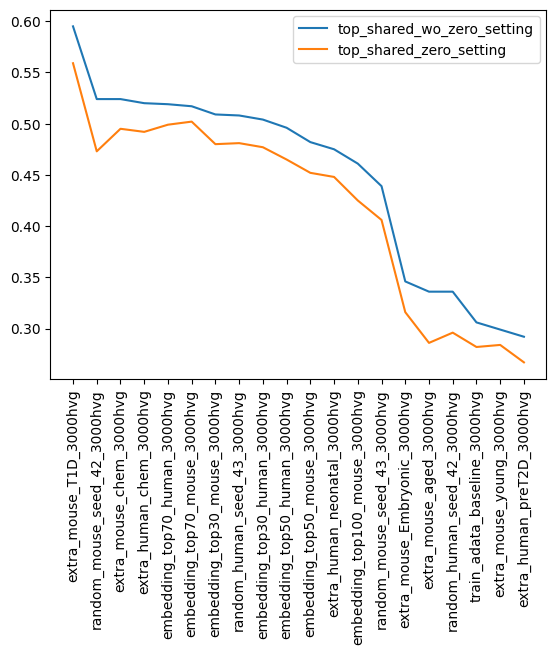

In [261]:
import matplotlib.pyplot as plt

results = results.sort_values("top_shared_wo_zero_setting", ascending=False)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column
for column in results.columns:
    ax.plot(results.index, results[column], label=column)

# Set x-axis ticks to be the categories from the index
ax.set_xticks(results.index)

# Rotate X-axis labels for better readability
plt.xticks(rotation=90)

# Adding a legend to differentiate columns
ax.legend()
plt.savefig("./fig_211123/zero_setting_check.png")
# Show the plot
plt.show()
